# 混合正規分布について正規分布モデルで信頼区間を求めた場合

黒木玄

2019-08-17～2019-08-19

See also https://twitter.com/genkuroki/status/1162625170034446336

## 追記
元ファイルにコメントを追加してあります。

<h1>目次<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#標準正規分布が真の分布の場合" data-toc-modified-id="標準正規分布が真の分布の場合-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>標準正規分布が真の分布の場合</a></span></li><li><span><a href="#外れ値を除けば正規分布に見える混合正規分布が真の分布の場合" data-toc-modified-id="外れ値を除けば正規分布に見える混合正規分布が真の分布の場合-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>外れ値を除けば正規分布に見える混合正規分布が真の分布の場合</a></span><ul class="toc-item"><li><span><a href="#サンプルサイズ100の場合" data-toc-modified-id="サンプルサイズ100の場合-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>サンプルサイズ100の場合</a></span></li><li><span><a href="#サンプルサイズ200の場合" data-toc-modified-id="サンプルサイズ200の場合-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>サンプルサイズ200の場合</a></span></li><li><span><a href="#サンプルサイズ30の場合" data-toc-modified-id="サンプルサイズ30の場合-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>サンプルサイズ30の場合</a></span></li></ul></li><li><span><a href="#おまけ：-正規分布とのあいだのKullback-Leibler情報量の計算" data-toc-modified-id="おまけ：-正規分布とのあいだのKullback-Leibler情報量の計算-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>おまけ： 正規分布とのあいだのKullback-Leibler情報量の計算</a></span></li></ul></div>

## ライブラリの読み込みとシードの固定

In [1]:
using Distributions
using Plots
pyplot(size=(400,250), fmt=:svg)
using Random: seed!
myseed = 2019

2019

## `sim_mean()`の定義

* true_dist = サイズnのサンプルを生成する確率分布 = 真の分布  (デフォルト値: Normal() = 標準正規分布)
* μ = 真の分布の平均 = 真の平均
* σ = 真の分布の標準偏差
* α = 有意水準  (1 - α が信頼区間の信頼係数になる)  (デフォルト値: 0.05)
* n = サンプルサイズ  (デフォルト値: 100)
* N_iters = サンプル生成を繰り返す回数  (デフォルト値: 10^6)
* z_tdist = t分布において P(X > z) = α/2 となる z
* z_normal = 標準正規分布において P(X > z) = α/2 となる z
* P_tdist = t分布を使って計算した平均の信用区間に真の平均が含まれる割合
* P_normal = 真の分布と同じ分散を持つ正規分布モデルで計算した平均の信用区間に真の平均が含まれる割合

P_tdist と P_normal は 1 - α に近くあって欲しい.

P_normal の計算では「真の分布の分散が既知」という非現実的な仮定を使っていることに注意せよ.  「真の分布の分散が未知」の場合の P_tdist との比較のために P_normal も同時に計算することにした.

### メモ
- [Distributions.jl, cquantile](https://juliastats.org/Distributions.jl/stable/univariate/#Distributions.cquantile-Tuple{Distribution{Univariate,S}%20where%20S%3C:ValueSupport,Real})

> cquantile(d::UnivariateDistribution, q::Real)

> The complementary quantile value, i.e. quantile(d, 1-q).

In [2]:
function sim_mean(;true_dist=Normal(), α=0.05, n=100, N_iters=10^6, μ=mean(true_dist), σ=std(true_dist))
    @show true_dist # サイズnのサンプルを生成する確率分布 = 真の分布  (デフォルト値: Normal() = 標準正規分布)
    @show μ # 真の分布の平均 = 真の平均
    @show σ # 真の分布の標準偏差
    @show α # 有意水準  (1 - α が信頼区間の信頼係数になる)
    @show n  # サンプルサイズ
    @show N_iters # サンプル生成を繰り返す回数
    M = zeros(N_iters) # sample means
    U = zeros(N_iters) # unbiased variances
    N_tdist = 0
    N_normal = 0
    z_tdist = cquantile(TDist(n-1), α/2) # t分布において P(X > z) = α/2 となる z
    z_normal = cquantile(Normal(), α/2)  #  標準正規分布において P(X > z) = α/2 となる z
    @show z_tdist
    @show z_normal
    for i in 1:N_iters
        X = rand(true_dist, n)
        M[i] = mean(X)
        U[i] = std(X)
        N_tdist += (M[i] - z_tdist*U[i]/√n ≤ μ ≤ M[i] + z_tdist*U[i]/√n)
        N_normal += (M[i] - z_normal*σ/√n ≤ μ ≤ M[i] + z_normal*σ/√n)
    end
    P_tdist = N_tdist/N_iters   #  t分布を使って計算した平均の信用区間に真の平均が含まれる割合
    P_normal = N_normal/N_iters # 真の分布と同じ分散を持つ正規分布モデルで計算した平均の信用区間に真の平均が含まれる割合
    @show P_tdist
    @show P_normal
    M, U, P_tdist, P_normal
end

sim_mean (generic function with 1 method)

## plotCIs, plot1000CIs の定義
TODO：CIは何の略？

In [3]:
function plotCIs(true_dist, M, U, α, n, indices=1:500)
    μ = mean(true_dist)
    z_tdist = cquantile(TDist(n-1), α/2)
    plot(; size=(1000, 150), legend=false)
    for i in indices
        A = M[i] - z_tdist*U[i]/√n
        B = M[i] + z_tdist*U[i]/√n
        color = A ≤ μ ≤ B ? :cyan : :red 
        plot!([i,i], [A,B], color=color)
    end
    plot!([minimum(indices), maximum(indices)], [μ, μ], color=:black, ls=:dot)
end

function plot1000CIs(true_dist, M, U, α, n)
    P1 = plotCIs(true_dist, M, U, α, n, 1:500)
    P2 = plotCIs(true_dist, M, U, α, n, 501:1000)
    plot(P1, P2, size=(1000, 300), layout=grid(2,1))
end

plot1000CIs (generic function with 1 method)

## 標準正規分布が真の分布の場合

true_dist = Normal{Float64}(μ=0.0, σ=1.0)
μ = 0.0
σ = 1.0
α = 0.05
n = 100
N_iters = 1000000
z_tdist = 1.9842169515864176
z_normal = 1.9599639845400592
P_tdist = 0.949843
P_normal = 0.949918


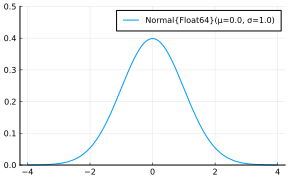

In [4]:
seed!(myseed)
n = 100
true_dist = Normal()
M, U, P_tdist, P_normal = sim_mean(true_dist=true_dist, n=n)
plot(x->pdf(true_dist, x), -4, 4; label="$true_dist", ylim=(0, 0.5))

### シミュレーション結果
真の分布が標準正規分布のときには, P_tdist も P_normal もほぼ理論値の 0.95 になっている. シミュレーションに伴う誤差があるのでぴったり0.95にはならない.

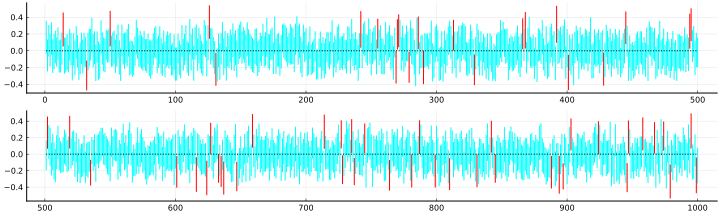

In [5]:
plot1000CIs(true_dist, M, U, 0.05, n)

### ヒストグラムと正規分布近似

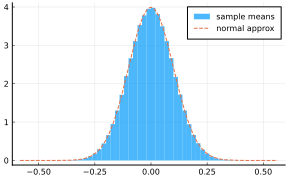

In [6]:
μ = mean(true_dist)
σ = std(true_dist)
histogram(M; normed=true, lw=0, bins=60, label="sample means", alpha=0.7)
plot!(x->pdf(Normal(μ, σ/√n), x), label="normal approx", ls=:dash)

### $(n-1) U^2 / \sigma^2$ のヒストグラムとカイ二乗分布
正規分布の再生性より, サンプル平均も正規分布に従う.

#### 注意
真の分布が正規分布のとき, 真の分布の分散を $\sigma^2$ と書き, サイズ $n$ サンプルの不偏分散を $U^2$ と書くとき, $(n-1)U^2/\sigma^2$ は自由度 $n-1$ のカイ二乗分布に従う.

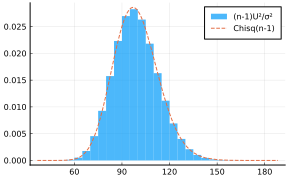

In [7]:
histogram((n-1)*U.^2/σ^2, normed=true, lw=0, bins=40, label="(n-1)U²/σ²", alpha=0.7)
plot!(x->pdf(Chisq(n-1), x); label="Chisq(n-1)", ls=:dash)

## 外れ値を除けば正規分布に見える混合正規分布が真の分布の場合

標準正規分布に「外れ値」に見える成分を混ぜた混合正規分布の場合にはどうなるだろうか?

サンプルを生成する真の分布として, 標準正規分布と平均50分散100の正規分布を $95\% : 5\%$ の比で混ぜた混合正規分布を採用しよう.

### サンプルサイズ100の場合

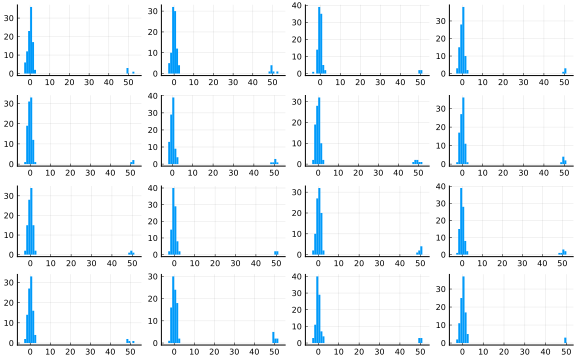

In [8]:
seed!(myseed)
n = 100
mixnormal = MixtureModel([Normal(), Normal(50.0, 1.0)], [0.95, 0.05])
true_dist = mixnormal

PP = []
for i in 1:16
    X = rand(true_dist, n)
    P = histogram(X; label="", bins=50)
    push!(PP, P)
end
plot(PP...; lw=0, layout=grid(4,4), size=(800, 500))

#### 真の分布のプロット

true_dist = MixtureModel{Normal{Float64}}(K = 2)
components[1] (prior = 0.9500): Normal{Float64}(μ=0.0, σ=1.0)
components[2] (prior = 0.0500): Normal{Float64}(μ=50.0, σ=1.0)

μ = 2.5
σ = 10.943034314119645
α = 0.05
n = 100
N_iters = 1000000
z_tdist = 1.9842169515864176
z_normal = 1.9599639845400592
P_tdist = 0.892252
P_normal = 0.961028
 29.341098 seconds (209.35 M allocations: 5.919 GiB, 5.80% gc time)


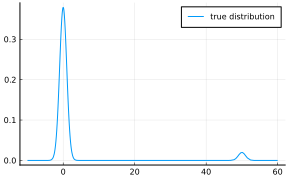

In [9]:
@time M, U, P_tdist, P_normal = sim_mean(true_dist=true_dist, n=n)
plot(x->pdf(true_dist, x), -10, 60; label="true distribution")

#### 注意
t分布を使って機械的に計算した平均の信用区間に真の平均が含まれる割合 P_tdist が89%程度に下がってしまっていることに注意せよ.  (P_normal が95%に近い値なってくれているのは, 真の分布の分散が既知であるという非現実的な仮定を使っているからである.)

このような場合があるので, サンプルの様子をプロットする場合には信用区間だけではなく, サンプルの分布そのものがある程度分かるようにしてもらえると「無駄に疑う手間」が不要になるし, サンプルの分布の様子を確認することを忘れるという初歩的な誤りも防ぐことにも役に立つだろう.

#### plot1000CIs

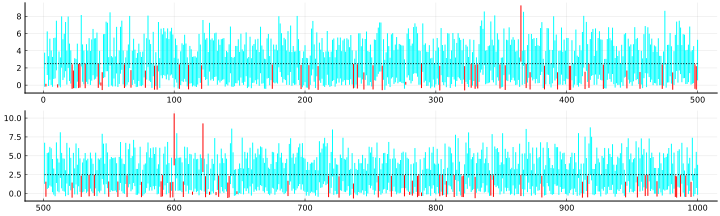

In [10]:
plot1000CIs(true_dist, M, U, 0.05, n)

#### サンプル平均のヒストグラムと正規分布近似

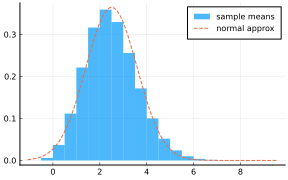

In [11]:
μ = mean(true_dist)
σ = std(true_dist)
histogram(M; normed=true, lw=0, bins=30, label="sample means", alpha=0.7)
plot!(x->pdf(Normal(μ, σ/√n), x), label="normal approx", ls=:dash)

#### $(n-1) U^2 / \sigma^2$ のヒストグラムとカイ二乗分布
真の分布が正規分布のとき, 真の分布の分散を $\sigma^2$ と書き, サイズ $n$ サンプルの不偏分散を $U^2$ と書くとき, $(n-1)U^2/\sigma^2$ は自由度 $n-1$ のカイ二乗分布に従う.  しかし, 上の場合に真の分布は正規分布ではなく, 正規分布からほど遠いので, $(n-1)U/\sigma^2$ が従う分布は自由度 $n-1$ のカイ二乗分布とは大きく異なる. 

しかも, $(n-1)U/\sigma^2$ の分散は自由度 $n-1$ のカイ二乗分布よりも大きい. $U$ の値が小さくなり過ぎる場合が無視できないほど多くなっている.

t分布を使った信頼区間は, サンプル平均を $\overline{X}$ と書き, サンプルの不偏分散の平方根を $U$ 書くとき, 

$$
\overline{X} - z_{\mathrm{tdist}}\frac{U}{\sqrt{n}}
\leqq
\mu
\leqq
\overline{X} + z_{\mathrm{tdist}}\frac{U}{\sqrt{n}}
$$

と表わされる. $U$ の値が小さくなり過ぎるとこの区間に真の平均が含まれ難くなってしまう.

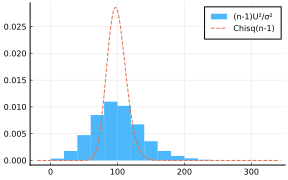

In [12]:
histogram((n-1)*U.^2/σ^2, normed=true, lw=0, bins=20, label="(n-1)U²/σ²", alpha=0.7)
plot!(x->pdf(Chisq(n-1), x); label="Chisq(n-1)", ls=:dash)

### サンプルサイズ200の場合

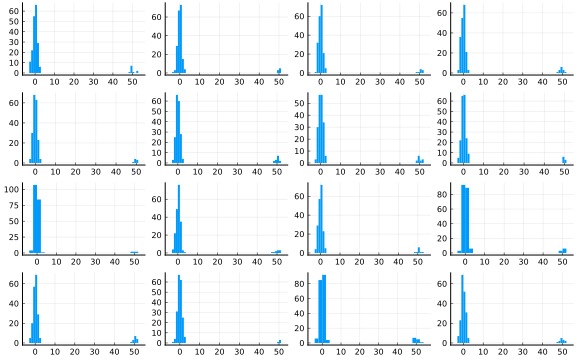

In [13]:
seed!(myseed)
n = 200
true_dist = mixnormal

PP = []
for i in 1:16
    X = rand(true_dist, n)
    P = histogram(X; label="", bins=50)
    push!(PP, P)
end
plot(PP...; lw=0, layout=grid(4,4), size=(800, 500))

#### 真の分布 

true_dist = MixtureModel{Normal{Float64}}(K = 2)
components[1] (prior = 0.9500): Normal{Float64}(μ=0.0, σ=1.0)
components[2] (prior = 0.0500): Normal{Float64}(μ=50.0, σ=1.0)

μ = 2.5
σ = 10.943034314119645
α = 0.05
n = 200
N_iters = 1000000
z_tdist = 1.9719565442517524
z_normal = 1.9599639845400592
P_tdist = 0.929822
P_normal = 0.951806
 76.751986 seconds (409.00 M allocations: 11.221 GiB, 4.03% gc time)


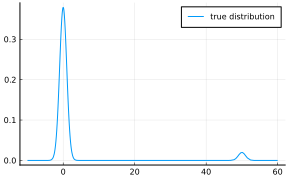

In [14]:
@time M, U, P_tdist, P_normal = sim_mean(true_dist=true_dist, n=n)
plot(x->pdf(true_dist, x), -10, 60; label="true distribution")

サンプルサイズを200にすると P_tdist が 0.93 程度とかなり 0.95 に近くなる.

しかし, サンプルサイズを大きくできるならば数学的モデルをもっとしっかり作って分析した方が良いと思われる. 

サンプルサイズを大きくして, 2つの山を持つ分布であることがわかったのであれば, どうしてそのような分布になったかについて考えた方が良いだろう.

#### plot1000CIs

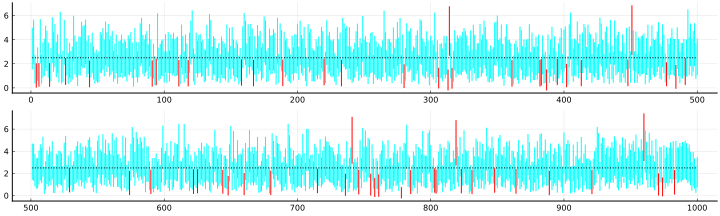

In [15]:
plot1000CIs(true_dist, M, U, 0.05, n)

#### サンプル平均と正規分布近似

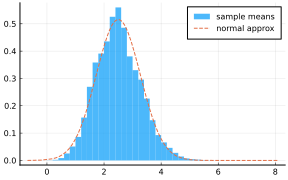

In [16]:
μ = mean(true_dist)
σ = std(true_dist)
histogram(M; normed=true, lw=0, bins=40, label="sample means", alpha=0.7)
plot!(x->pdf(Normal(μ, σ/√n), x), label="normal approx", ls=:dash)

#### $(n-1)U^2 / \sigma^2$のヒストグラムとカイ二乗分布

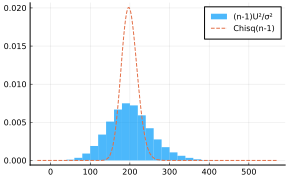

In [17]:
histogram((n-1)*U.^2/σ^2, normed=true, lw=0, bins=40, label="(n-1)U²/σ²", alpha=0.7)
plot!(x->pdf(Chisq(n-1), x); label="Chisq(n-1)", ls=:dash)

### サンプルサイズ30の場合

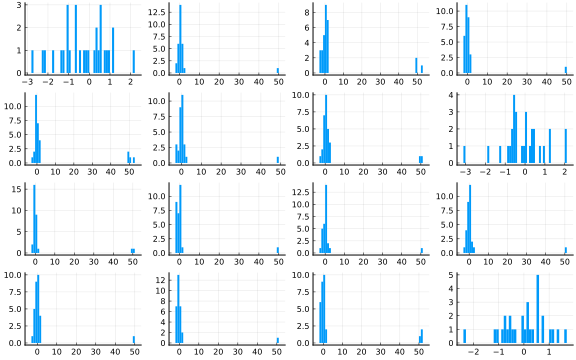

In [18]:
seed!(myseed)
n = 30
true_dist = mixnormal

PP = []
for i in 1:16
    X = rand(true_dist, n)
    P = histogram(X; label="", bins=50)
    push!(PP, P)
end
plot(PP...; lw=0, layout=grid(4,4), size=(800, 500))

#### 真の分布

true_dist = MixtureModel{Normal{Float64}}(K = 2)
components[1] (prior = 0.9500): Normal{Float64}(μ=0.0, σ=1.0)
components[2] (prior = 0.0500): Normal{Float64}(μ=50.0, σ=1.0)

μ = 2.5
σ = 10.943034314119645
α = 0.05
n = 30
N_iters = 1000000
z_tdist = 2.045229642132704
z_normal = 1.9599639845400592
P_tdist = 0.784609
P_normal = 0.942935
 11.321641 seconds (69.00 M allocations: 2.250 GiB, 5.23% gc time)


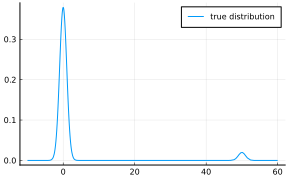

In [19]:
@time M, U, P_tdist, P_normal = sim_mean(true_dist=true_dist, n=n)
plot(x->pdf(true_dist, x), -10, 60; label="true distribution")

#### 結果の分析
サンプルサイズを30と小さくすると P_tdist が 0.78 程度とかなり小さくなってしまう.

その理由は以下のプロットを見ればわかるように, 母集団では5%だけ混じっている平均50の集団がサンプルに含まれない場合が多数出て来るからである.

そのような場合にはサンプルだけを見ると、単純に正規分布に近い分布をしているようにしか見えないだろう. しかし, 母集団の真の分布は正規分布に全然従っていない可能性は残っているのである.

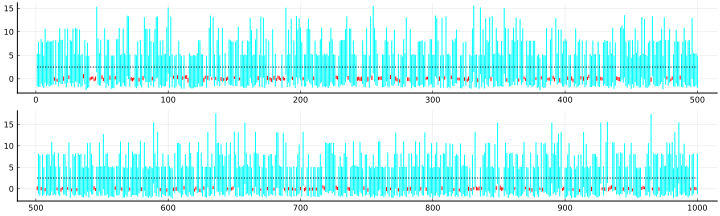

In [20]:
plot1000CIs(true_dist, M, U, 0.05, n)

#### サンプル平均と正規分布近似

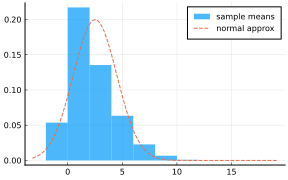

In [21]:
μ = mean(true_dist)
σ = std(true_dist)
histogram(M; normed=true, lw=0, bins=15, label="sample means", alpha=0.7)
plot!(x->pdf(Normal(μ, σ/√n), x), label="normal approx", ls=:dash)

#### $(n-1)U^2 / \sigma^2$のヒストグラムとカイ二乗分布

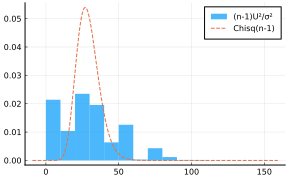

In [22]:
histogram((n-1)*U.^2/σ^2, normed=true, lw=0, bins=15, label="(n-1)U²/σ²", alpha=0.7)
plot!(x->pdf(Chisq(n-1), x); label="Chisq(n-1)", ls=:dash)

## おまけ： 正規分布とのあいだのKullback-Leibler情報量の計算

上で扱った混合正規分布は正規分布からほど遠い分布である.

どれだけ遠いかをKullback-Leibler情報量を計算することによって確認してみよう.

分布 $q$ と分布 $q$ を最良近似する正規分布 $p$ のKullback-Leibler情報量を `KLnormalapprox(q)` で計算できる.

In [23]:
using QuadGK

xtimesy(x,y) = (iszero(x) || !isfinite(x)) ? zero(x) : x*y
# 汎化誤差
GE(q, p) = quadgk(x->-xtimesy(pdf(q,x), logpdf(p,x)), -Inf, Inf)[1]
# エントロピー
S(q) = GE(q, q)
# カルバック-ライブラ情報量
KL(q, p) = GE(q, p) - S(q)

function KLnormalapprox(true_dist; xspan=nothing, kwargs...)
    μ, σ = mean(true_dist), std(true_dist)
    normal_approx = Normal(μ, σ)
    @show true_dist
    @show normal_approx
    @show KL(true_dist, normal_approx)
    if xspan == nothing
        x = range(μ-4σ, μ+4σ, length=400)
    else
        x = range(xspan[1], xspan[2], length=400)
    end
    plot(; kwargs...)
    plot!(x, pdf.(true_dist, x), label="true dist")
    plot!(x, pdf.(normal_approx, x), label="normal approx", ls=:dash)
end

KLnormalapprox (generic function with 1 method)

### 真の分布が正規分布

true_dist = Normal{Float64}(μ=0.0, σ=1.0)
normal_approx = Normal{Float64}(μ=0.0, σ=1.0)
KL(true_dist, normal_approx) = 0.0


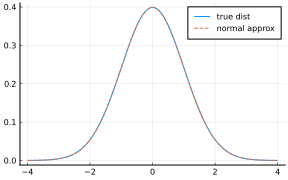

In [24]:
KLnormalapprox(Normal())

#### 結果
正規分布の場合にはカルバックライブラ情報量は 0 になる.

### 真の分布が混合正規分布の場合

true_dist = MixtureModel{Normal{Float64}}(K = 2)
components[1] (prior = 0.9500): Normal{Float64}(μ=0.0, σ=1.0)
components[2] (prior = 0.0500): Normal{Float64}(μ=50.0, σ=1.0)

normal_approx = Normal{Float64}(μ=2.5, σ=10.943034314119645)
KL(true_dist, normal_approx) = 1.7780971613907095


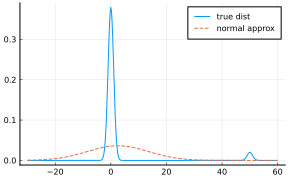

In [25]:
KLnormalapprox(mixnormal; xspan=(-30, 60))

#### 結果
mixnormalとそれを最良近似する正規分布のKL情報量で測った「距離」は1.8程度である.

### 真の分布が一様分布のとき

true_dist = Uniform{Float64}(a=0.0, b=1.0)
normal_approx = Normal{Float64}(μ=0.5, σ=0.28867513459481287)
KL(true_dist, normal_approx) = 0.17648520870373846


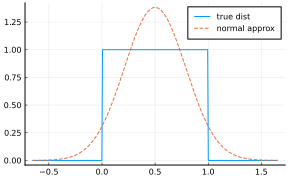

In [26]:
KLnormalapprox(Uniform())

#### 結果
一様分布は上と比較すると相対的に正規分布にかなり近い.

### 真の分布が指数分布

true_dist = Exponential{Float64}(θ=1.0)
normal_approx = Normal{Float64}(μ=1.0, σ=1.0)
KL(true_dist, normal_approx) = 0.4189385332046778


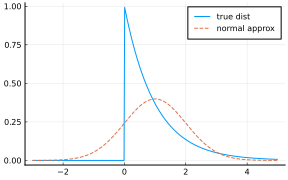

In [27]:
KLnormalapprox(Exponential())

#### 結果
上の混合正規分布mixnormalの場合と比較すると指数分布でさえ相対的に正規分布に近い.

### 真の分布がベータ分布

true_dist = Beta{Float64}(α=0.2, β=0.4)
normal_approx = Normal{Float64}(μ=0.3333333333333333, σ=0.3726779962499649)
KL(true_dist, normal_approx) = 2.1205826346728793


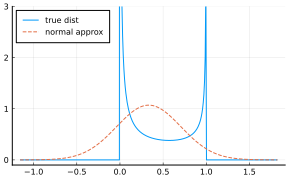

In [28]:
KLnormalapprox(Beta(0.2, 0.4); ylim=(-0.1, 3))

### 真の分布がガンマ分布

true_dist = Gamma{Float64}(α=0.25, θ=1.0)
normal_approx = Normal{Float64}(μ=0.25, σ=0.5)
KL(true_dist, normal_approx) = 2.3583589284264175


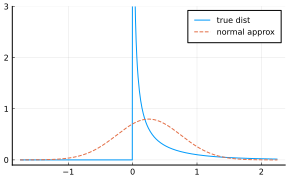

In [29]:
KLnormalapprox(Gamma(0.25, 1); ylim=(-0.1, 3))